In [ ]:
import numpy as np
import pandas as pd
import random
import pickle

import matplotlib.pyplot as plt

import seaborn as sns
import cebra
from cebra import CEBRA

from dataframe.csv_utils import (
    load_data_from_csv,
)
from data_utils import (
    load_data_from_dir,
)
from labels import get_behavioral_labels, get_raw_labels, get_label_means
from constants import AUDIO_BLOCKS
from feature_extraction import EEG_BANDS
from resample.resample import (
    get_validation_indexes,
)


data_dir = "../CleandDataV2/"
random.seed(33)

## Helper functions

In [ ]:
def get_categorical_labels(blocks, subject_data):
    behavioral_labels = []

    for b in blocks:
        block_data = subject_data[b]
        v_label = block_data.get_labels()
        a_label = block_data.get_labels("arousal")

        labels = [
            get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))
        ]
        behavioral_labels.extend(labels)

    return behavioral_labels


def get_label_category(labels, label_type, v_thred, a_thred):
    threshold = a_thred if label_type == "arousal" else v_thred
    return [0 if p < threshold else 1 for p in labels]

## Load data and process features

In [ ]:
# Read dictionary pkl file
with open('./eeg_features2/all_features.pkl', 'rb') as fp:
    marker_features = pickle.load(fp)
    print('Person dictionary')
len(marker_features)

In [ ]:
# Read labels pkl file
with open("./data/behavioral_labels.pkl", "rb") as fp:
    behavioral_labels = pickle.load(fp)

valence_labels, arousal_labels, attention_labels = (
    behavioral_labels["valence_labels"],
    behavioral_labels["arousal_labels"],
    behavioral_labels["attention_labels"],
)
print(len(valence_labels), len(valence_labels[0]))

In [ ]:
import os

marker = "EEG"
num_slice_per_trial = 5

subject_list = []
label_thresholds = []
idx = 0
for d in os.listdir(data_dir):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    vl, arl = valence_labels[idx], arousal_labels[idx]
    subject_list.append(d)
    label_thresholds.append((np.mean(vl), np.mean(arl)))
    idx += 1

### Slicing

In [ ]:
import os
from features.feature_utils import get_feature_to_data

marker = "EEG"
num_slice_per_trial = 5

subject_list = []
valence_labels, arousal_labels, attention_labels = [], [], []
label_thresholds = []
across_blocks_label_thresholds = []
for d in os.listdir(data_dir):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    subject_data = load_data_from_dir(dir_name)
    features = get_feature_to_data(subject_data, marker)
    vl, arl, atl = get_raw_labels(AUDIO_BLOCKS, subject_data, num_slice_per_trial)

    subject_list.append(d)
    marker_features.append(features)
    valence_labels.append(vl)
    arousal_labels.append(arl)
    attention_labels.append(atl)
    label_thresholds.append((np.mean(vl), np.mean(arl)))
    across_blocks_label_thresholds.append(get_label_means(subject_data))

# with open('data/behavioral_labels.pkl', 'wb') as handle:
#     d = {'attention_labels': attention_labels, 'valence_labels': valence_labels, 'arousal_labels': arousal_labels}
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

### No slicing

In [ ]:
marker = "EEG"
# [2001, 2003, 2017, 2026, 2028, 2033,  2037, 2041]
subj = 2041
subject_data = subj_to_data[subj]
num_slice_per_trial = 1

channel_feature_to_data = {"A": {}, "B": {}, "C": {}, "D": {}}
for c in ["A", "B", "C", "D"]:
    for f in EEG_BANDS.keys():
        raw_data = get_block_features(AUDIO_BLOCKS, subject_data, marker, c, f)
        channel_feature_to_data[c][f] = raw_data

## Model Training

### Dataset utils

In [ ]:
from plotting import plot_roc_curve
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score

# from importlib import reload
# import features.constants

# reload(features.constants)
from features.constants import Feature

def get_all_spectral_features(
    feature_to_data: dict, eeg_dataset, attention_labels, labels
):
    all_spetral_psd = [feature_to_data[f.name] for f in EEG_BANDS.keys()]
    all_spetral_psd = np.hstack(all_spetral_psd)
    return eeg_dataset.train_test_split(all_spetral_psd, labels)


def get_all_channel_features_by_bands(data: dict, eeg_dataset, labels, eeg_bands):
    all_spetral_psd = []
    for _, feature_to_data in data.items():
        spetral_psd = [feature_to_data[f.name] for f in eeg_bands]
        all_spetral_psd.extend(spetral_psd)

    all_spetral_psd = np.hstack(all_spetral_psd)
    return eeg_dataset.train_test_split(all_spetral_psd, labels)


def prepare_dataset(
    data,
    eeg_dataset,
    attention_labels,
    labels,
    has_all_spectral: bool = False,
    filtered_channel: str = "",
):
    if filtered_channel == "ALL":
        dataset_dict= {filtered_channel: {}}
        for f in EEG_BANDS.keys():
            dataset_dict['ALL'][f.name] = get_all_channel_features_by_bands(
                data, eeg_dataset, labels, [f]
            )

        dataset_dict["ALL"][
            Feature.ALL_SPECTRAL.name
        ] = get_all_channel_features_by_bands(
            data, eeg_dataset, labels, list(EEG_BANDS.keys())
        )

        return dataset_dict

    dataset_dict = {k: {} for k in data.keys()}
    for channel, feature_to_data in data.items():
        if len(feature_to_data) == 0 or (
            channel != filtered_channel and len(filtered_channel) > 0
        ):
            continue

        if has_all_spectral:
            dataset_dict[channel][Feature.ALL_SPECTRAL.name] = get_all_spectral_features(
                feature_to_data, eeg_dataset, attention_labels, labels
            )
            continue

        for f, neural_data in feature_to_data.items():
            # Prepare the data
            dataset_dict[channel][f] = eeg_dataset.train_test_split(neural_data, labels)
    return dataset_dict

### Training utils

In [ ]:
# CEBRA hyper-parameters
OUTPUT_DIM = 8
MAX_HIDDEN_UNITS = 256
from model.embedding import get_embeddings

# output_dim, max_hidden_units only needed for CEBRA
def run_knn_decoder(
    dataset,
    method,
    threshold,
    output_dim,
    max_hidden_units,
    n_neighbors: int = 36,
):
    y_pred, y_pred_cat, all_embeddings = [], [], []
    for idx, (train_data, train_labels, val_data, _) in enumerate(dataset):
        embedding, val_embedding = get_embeddings(
            train_data=train_data,
            val_data=val_data,
            train_labels=train_labels,
            use_pca=(method == "PCA"),
            out_dim= 6 if method == "PCA" else output_dim,
            num_hidden_units=max_hidden_units,
            max_iterations=1000,
        )

        all_embeddings.append((embedding, val_embedding))
        # 4. Train the decoder on training embedding and labels
        # train_true_cat = get_label_category(train_labels, label_type)
        decoder = cebra.KNNDecoder(n_neighbors=n_neighbors, metric="cosine")
        decoder.fit(embedding, np.array(train_labels))

        # score = decoder.score(val_embedding, np.array(val_labels))
        prediction = decoder.predict(val_embedding)
        y_pred.append(prediction)
        y_pred_cat.append([0 if p < threshold else 1 for p in prediction])

    return y_pred, y_pred_cat, all_embeddings

def _plot_embeddings_breakdown(list_embedding_tuple, method, label_type):
    import plotly.express as px

    for (title, embeddings, embedding_labels) in list_embedding_tuple:
        if 'GAMMA' in title:
            components = embeddings
            color = embedding_labels
            break

    n_components = components.shape[-1]
    labels = {str(i): f"L {i+1}" for i in range(n_components)}
    
    fig = px.scatter_matrix(
        components,
        labels=labels,
        dimensions=range(n_components),
        color=color,
        range_color=[0, 1],
        #size_max=3,
        title=f'{method} embedding - {label_type}',
        height=800, width=800
    )
    
    fig.update_layout({"xaxis"+str(i+1): dict(showticklabels = False) for i in range(n_components)})
    fig.update_layout({"yaxis"+str(i+1): dict(showticklabels = False) for i in range(n_components)})
    fig.update_traces(marker=dict(size=3))
    fig.update_traces(diagonal_visible=False)
    fig.show()


def decode_marker_data(
    dataset_dict,
    label_type,
    v_thred,
    a_thred,
    method,
    threshold,
    plot_roc: bool = False,
):
    f1_score_data = {k: {} for k in dataset_dict.keys()}
    accuracy = {k: {} for k in dataset_dict.keys()}
    list_embedding_tuple = []
    for channel, feature_to_data in dataset_dict.items():
        if len(feature_to_data) == 0:
            continue

        for f, dataset in feature_to_data.items():
            val_true_cat = [
                get_label_category(val_labels, label_type, v_thred, a_thred)
                for _, (_, _, _, val_labels) in enumerate(dataset)
            ]

            y_pred, val_pred_cat, all_embeddings = run_knn_decoder(
                dataset,
                method,
                threshold,
                OUTPUT_DIM,
                MAX_HIDDEN_UNITS,
            )

            if plot_roc:
                plot_roc_curve(y_pred, val_true_cat, method, label_type, channel, f)

            score = [
                f1_score(y_pred=val_pred_cat[i], y_true=val_true_cat[i])
                for i in range(len(val_pred_cat))
            ]
            ac_scores = [
                accuracy_score(y_pred=val_pred_cat[i], y_true=val_true_cat[i])
                for i in range(len(val_pred_cat))
            ]

            max_score_index = np.array(ac_scores).argmax(axis=0)
            mean_acc = round(np.mean(ac_scores),2) 
            max_acc = round(ac_scores[max_score_index], 2)
            list_embedding_tuple.append(
                (
                    f"CV Acc Max: {max_acc} Avg:{mean_acc}",
                    max_score_index,
                    all_embeddings[max_score_index],
                    (dataset[max_score_index][1], dataset[max_score_index][3]),
                )
            )

            f1_score_data[channel][f] = np.mean(score)
            accuracy[channel][f] = np.mean(ac_scores)
       
    return list_embedding_tuple, accuracy

### Cross Validation

In [ ]:
from resample.resample import get_consecutive_validation_indexes

n_step_trial = 3
val_indexes = [
    get_consecutive_validation_indexes(
        len(valence_labels[0]), len(AUDIO_BLOCKS), num_slice_per_trial, i, n_step_trial
    )
    for i in range(1, 13, n_step_trial)
]
print(len(val_indexes), val_indexes)

### Get subjects summary

In [ ]:
from model.dataset import EEGDataset

eeg_dataset = EEGDataset(val_indexes_group=val_indexes)
shuffled_indexes = eeg_dataset.get_shuffled_indexes(valence_labels[0], False)

In [ ]:
def get_feature_names_and_mean_scores(
    dataset_dict, accuracy, marker: str, filtered_channel: str
):
    if marker != "EEG":
        return list(dataset_dict[marker].keys()), [
            accuracy[marker][f] for f in all_feature_name
        ]

    if len(filtered_channel) == 0:
        all_feature_name = list(dataset_dict.keys())
        mean_scores = [accuracy[c][Feature.ALL_SPECTRAL] for c in all_feature_name]
    else:
        all_feature_name = list(accuracy[filtered_channel].keys())
        mean_scores = [accuracy[filtered_channel][f] for f in all_feature_name]

    return all_feature_name, mean_scores


subject_accuracy_summary = {
    "subject": [],
    "channel": [],
    "label_type": [],
    "cv_mean_score": [],
}

###CHANGE ME####
method = 'CEBRA'
filtered_channel = "ALL"
combined_all_spectral = True
plot_roc = False
###############
test_list = subject_list #['2001', '2005', '2031']

subject_to_embedding = { s: {'valence': [], 'arousal': []} for s in test_list}

for idx in range(len(subject_list)):
    if subject_list[idx] not in test_list:
        continue

    subj = subject_list[idx]
    print('decoding subject...', subj)

    v_thred, a_thred = label_thresholds[idx]
    for lt in ["valence", "arousal"]:
        labels = valence_labels[idx] if lt == "valence" else arousal_labels[idx]
        thred = v_thred if lt == "valence" else a_thred

        dataset_dict = prepare_dataset(
            marker_features[idx],
            eeg_dataset,
            [],
            labels,
            combined_all_spectral,
            filtered_channel,
        )

        subject_to_embedding[subj][lt], accuracy = decode_marker_data(
            dataset_dict, lt, v_thred, a_thred, method, thred, plot_roc
        )

        all_feature_name, mean_scores = get_feature_names_and_mean_scores(
            dataset_dict, accuracy, marker, filtered_channel
        )

        subject_accuracy_summary["subject"].extend(
            [subj] * len(all_feature_name)
        )
        subject_accuracy_summary["channel"].extend(all_feature_name)
        subject_accuracy_summary["cv_mean_score"].extend(mean_scores)
        subject_accuracy_summary["label_type"].extend([lt] * len(all_feature_name))

subject_accuracy_summary = pd.DataFrame(subject_accuracy_summary)
subject_accuracy_summary["subject"] = subject_accuracy_summary["subject"].astype(int)

In [ ]:
identifier = '1000iter_c_all_spectral'

In [ ]:
with open(f'results/models/{method}_{identifier}_embeddings.pkl', 'wb') as handle:
    pickle.dump(subject_to_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
subject_accuracy_summary["channel"] = subject_accuracy_summary["channel"].astype(str)
subject_accuracy_summary.to_csv(f'results/{method}_{identifier}.csv')

In [ ]:
with open(f'results/models/shuffled_indexes.pkl', 'wb') as handle:
    d = {'shuffled_indexes': shuffled_indexes}
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plot CV mean score

/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


Text(0.5, 1.0, 'Across channel spectral - CEBRA ')

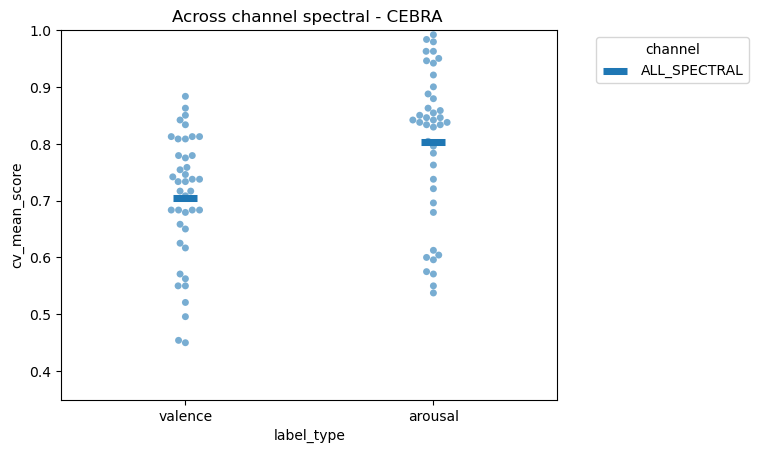

In [40]:
data = subject_accuracy_summary
title = f"Across channel spectral - {method} "  #
g = sns.swarmplot(
    data=data,
    x="label_type",
    y="cv_mean_score",
    hue="channel",
    # hue_order=[
    #     "DELTA",
    #     "THETA",
    #     "ALPHA",
    #     "BETA1",
    #     "BETA2",
    #     "GAMMA",
    #     'ALL_SPECTRAL',
    # ],    
    alpha=0.6,
    dodge=True,
    legend=False,
)
g.set_ylim((0.35, 1))

df_means = (
    data.groupby(["label_type", "channel"])["cv_mean_score"].agg("mean").reset_index()
)
pp = sns.pointplot(
    x="label_type",
    y="cv_mean_score",
    data=df_means,
    hue="channel",
    dodge=0.6,
    linestyles="",
    errorbar=None,
    scale=2.5,
    markers="_",
    # hue_order=[
    #     "DELTA",
    #     "THETA",
    #     "ALPHA",
    #     "BETA1",
    #     "BETA2",
    #     "GAMMA",
    #     'ALL_SPECTRAL',
    # ],
    order=["valence", "arousal"],
)

sns.move_legend(pp, "upper right", bbox_to_anchor=(1.4, 1))
g.set_title(title)

In [ ]:
sns.relplot(
    data=subject_accuracy_summary,
    x="ari_scores", y="cv_mean_score", hue="label_type", col="channel",
)

## Plot embeddings

In [ ]:
colorMap = {'valence': '#94b325', 'arousal': '#595eeb'}
label_type = 'arousal'
best_embedding_idx = []

for i, s in enumerate(subject_list):
    (
        _,
        max_idx,
        (embeddings, val_embeddings),
        (embedding_labels, val_embedding_labels),
    ) = subject_to_embedding[s][label_type][0]
    abs_corr = []
    for idx in range(embeddings.shape[-1]):
        corr = np.corrcoef(embeddings[:, idx], embedding_labels)[0, 1]
        abs_corr.append(np.abs(corr))
    
    max_score_index = np.array(abs_corr).argmax(axis=0)
    best_embedding_idx.append(max_score_index)

n_row, n_col = (5, 8)
f, axarr = plt.subplots(n_row, n_col, figsize=(3 * n_col, 3 * n_row), sharey=True)
for idx, ax in enumerate(axarr.flat):
    s = subject_list[idx]
    l = f'L{best_embedding_idx[idx]}'
    (
        name,
        max_idx,
        (embeddings, val_embeddings),
        (embedding_labels, val_embedding_labels),
    ) = subject_to_embedding[s][label_type][0]

    result = pd.DataFrame({l: embeddings[:, best_embedding_idx[idx]], 'labels': embedding_labels})
    sns.regplot(data=result, ci=99, x=l, y='labels', color=colorMap[label_type], line_kws=dict(color="r"), ax=ax)    
    corr = np.corrcoef(result[l], embedding_labels)[0, 1]
    ax.text(
        0.1,
        0.95,
        "$r$ = {:.3f}".format(corr),
        horizontalalignment="left",
        verticalalignment="center",
        color='red',
        fontweight='heavy',
        transform=ax.transAxes,
        size=12,
    )    
    ax.set_title(f'{s}:{name}')
    ax.set(ylim=(0, 1))
f.tight_layout(pad=1.8)

## Attention investigation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import math

test = np.array(attention_labels).ravel()
test = np.power(test, 1)
test = np.array(list(map(cutoff, test)))
scaler = MinMaxScaler(feature_range=(0, 1))
weights = scaler.fit_transform(test.reshape(-1, 1))

# Pass the NumPy array into the function


g = sns.histplot(
    data=mean_validation_score, stat="probability", cumulative=True
)
g.set_title("41 subjects attention rating in test")
g.axvline(np.mean(mean_validation_score), c="k", ls="-", lw=2.5)
g.axvline(np.median(mean_validation_score), c="orange", ls="--", lw=2.5)
g.set_ylim((0, 1))
g.set_xlim((0, 1))
#sns.displot(penguins, x="flipper_length_mm", kind="ecdf")

In [ ]:
# Define a  function to square elements
def cutoff(x):
    return math.pow(x, -2) if x > 50 else x

def nupsample_by_attention(attention, num_output):
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0, 100))
    rating = np.array(attention).ravel()
    
    weights = scaler.fit_transform(np.power(rating, 1).reshape(-1, 1))
    weights = np.array(list(map(cutoff, weights.ravel())))

    resampled_features = random.choices(
        np.arange(0, len(attention), 1), weights=weights, k=num_output
    )

    return np.array(resampled_features)

def nget_resampled_list_index(train_indexes, attention_labels):
    # exclude validation
    train_attention_labels = np.array(attention_labels)[train_indexes]
    # up sample 4 times by attention labels
    resampled_list = nupsample_by_attention(
        train_attention_labels, len(train_attention_labels) * 4
    )
    return resampled_list

resampled_attention_list = []
for a in range(len(attention_labels)):
    for i in range(len(val_indexes)):
        train_indexes = list(set(range(len(attention_labels[a]))) - set(val_indexes[i]))
        resampled_list = nget_resampled_list_index(train_indexes, attention_labels[a])
        attention_list = np.array(attention_labels[a])[train_indexes][resampled_list]
        resampled_attention_list.append(attention_list.tolist())

In [ ]:
g = sns.histplot(
    data=np.array(resampled_attention_list).ravel(), stat="probability", cumulative=False
)
g.set_title("41 subjects w weighted attention distribution")
g.axvline(np.mean(np.array(resampled_attention_list)), c="k", ls="-", lw=2.5)
g.axvline(np.median(np.array(resampled_attention_list)), c="orange", ls="--", lw=2.5)
g.set_ylim((0, 0.2))
g.set_xlim((0, 1))

## MiSC: Loss/Grid search

In [ ]:
nrows = 1
ncols = len(loss_data)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharey=True,
    figsize=(ncols * 5, nrows * 5),
)

fig.suptitle(
    f"Subject {subj}: {marker} {label_type} InfoNCE loss in audio condition",
    fontsize=15,
)

for c, ax in zip(loss_data.keys(), axes.flatten()):
    df = pd.DataFrame(loss_data[c])
    sns.lineplot(data=df, ax=ax)
    ax.set_title("channel:" + c)
    ax.set_ylabel("InfoNCE Loss")
    ax.set_xlabel("Steps")
# plt.savefig(f"results/cebra/{label_type}_{subj}_eeg_bands_channel_loss_{channel}_O{output_dim}H{max_hidden_units}.png")

In [ ]:
loss_dict = {"InfoNCE Loss": [], "band": [], "channel": [], "Steps": []}
for c, f_to_data in loss_data.items():
    for f, data in f_to_data.items():
        loss_dict["InfoNCE Loss"].extend(np.array(data))
        loss_dict["Steps"].extend(np.arange(0, len(data), dtype=int))
        loss_dict["band"].extend([f] * len(data))
        loss_dict["channel"].extend([c] * len(data))

loss_dict = pd.DataFrame(loss_dict)
loss_dict

In [ ]:
sns.lineplot(data=loss_dict, y="InfoNCE Loss", x="Steps", hue="band", style="channel")

In [ ]:
# 1. Define the parameters, either variable or fixed
params_grid = dict(
    output_dimension=[6, 8],
    learning_rate=[3e-4],
    max_iterations=10,
    num_hidden_units=[32, 64, 128, 256],
    max_adapt_iterations=10,
    temperature_mode="auto",
    verbose=False,
)

# 2. Define the datasets to iterate over
datasets = {
    "neural_data": channel_feature_to_data["C"][Feature.THETA],
}

# 3. Create and fit the grid search to your data
grid_search = cebra.grid_search.GridSearch()
grid_search = grid_search.fit_models(
    datasets=datasets, params=params_grid, models_dir="saved_models"
)

# 4. Get the results
df_results = grid_search.get_df_results(models_dir="saved_models")
# 5. Get the best model for a given dataset
best_model, best_model_name = grid_search.get_best_model(
    dataset_name="neural_data", models_dir="saved_models"
)